[[ 977  977  978 ... 1001 1000 1000]
 [ 976  976  976 ... 1000  999  999]
 [ 974  975  975 ...  999  998  998]
 ...
 [ 601  602  602 ...  602  602  602]
 [ 601  601  601 ...  602  602  601]
 [ 600  600  600 ...  601  601  601]]


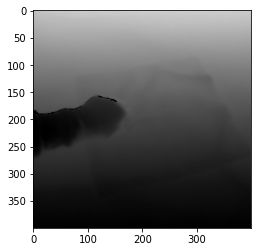

In [117]:
import cv2
import numpy as np
import matplotlib.pyplot as plt


depth = cv2.imread("data/imgs/0506_10k/depth_30.jpg")
plt.imshow(depth)

depth_raw = np.load("data/imgs/0506_10k/depth_30.npy")
print(depth_raw)

Datapoints: 6667


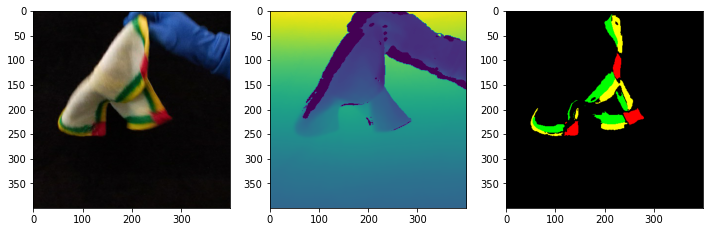

tensor([[0.9821, 0.9821, 0.9837,  ..., 0.9445, 0.9429, 0.9429],
        [0.9804, 0.9804, 0.9804,  ..., 0.9429, 0.9413, 0.9396],
        [0.9772, 0.9772, 0.9772,  ..., 0.9413, 0.9396, 0.9380],
        ...,
        [0.3361, 0.3361, 0.3361,  ..., 0.3263, 0.3263, 0.3279],
        [0.3344, 0.3344, 0.3344,  ..., 0.3263, 0.3263, 0.3279],
        [0.3344, 0.3344, 0.3344,  ..., 0.3246, 0.3246, 0.3246]])


In [124]:
import random
import os
import cv2
import random
from PIL import Image
from utils import normalize
import numpy as np

import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import utils
import torchvision.transforms.functional as tf
import torchvision.transforms as T

class TowelDataset(Dataset):

    def __init__(self, root_dir, phase, use_transform=True, datasize=None):
        self.root_dir = root_dir
        self.phase = phase
        self.use_transform = use_transform

        filename = [f for f in os.listdir(self.root_dir) if f.startswith("color")]
        self.imgs = filename if datasize is None else filename[0:datasize]
#         print(self.imgs)

        if self.phase == 'train':
            self.total_data_num = int(len(self.imgs)/6*4) if len(self.imgs) > 8 else len(self.imgs)
        elif self.phase == 'val':
            self.total_data_num = int(len(self.imgs)/6)
        elif self.phase == 'test':
            self.total_data_num = int(len(self.imgs)/6)

        print("Datapoints: %d" % self.total_data_num)

    def __len__(self):
        return self.total_data_num

    def __getitem__(self, idx):
        if self.phase == 'val':
            idx = idx + self.total_data_num*4
        elif self.phase == 'test':
            idx = idx + self.total_data_num*5

#         imidx = self.imgs[idx].split("_")[1].replace(".png", "")
        imidx = self.imgs[idx].split("_")[1].replace(".jpg", "")
        img_path = os.path.join(self.root_dir, self.imgs[idx])
        depth_path = os.path.join(self.root_dir, "depth_" + imidx + ".npy")

        img_rgb = Image.open(img_path)

        depth_npy = np.load(depth_path)
        depth_npy[np.isnan(depth_npy)] = max_d = np.nanmax(depth_npy)
        
        depth_min, depth_max = 400., 1100.
        depth_npy = (depth_npy - depth_min) / (depth_max - depth_min)
        depth_npy = depth_npy.clip(0., 1.)
        
        img_depth = Image.fromarray(depth_npy)#, mode='F')

        transform = T.Compose([T.ToTensor()])
        if self.phase == 'test':
            if self.use_transform:
                img_rgb = transform(img_rgb)
                img_depth = transform(img_depth)
                mask = transform(mask)

            img_depth = normalize(img_depth)
            sample = {'rgb': img_rgb, 'X': img_depth}
        else:
            corners_label = Image.open(os.path.join(self.root_dir, 'label_red_'+imidx+'.png'))
            edges_label = Image.open(os.path.join(self.root_dir, 'label_yellow_'+imidx+'.png'))
            inner_edges_label = Image.open(os.path.join(self.root_dir, 'label_green_'+imidx+'.png'))

            if self.use_transform:
                if random.random() > 0.5:
                    img_rgb = tf.hflip(img_rgb)
                    img_depth = tf.hflip(img_depth)
                    corners_label = tf.hflip(corners_label)
                    edges_label = tf.hflip(edges_label)
                    inner_edges_label = tf.hflip(inner_edges_label)
                if random.random() > 0.5:
                    img_rgb = tf.vflip(img_rgb)
                    img_depth = tf.vflip(img_depth)
                    corners_label = tf.vflip(corners_label)
                    edges_label = tf.vflip(edges_label)
                    inner_edges_label = tf.vflip(inner_edges_label)
                if random.random() > 0.9:
                    angle = T.RandomRotation.get_params([-30, 30])
                    img_rgb = tf.rotate(img_rgb, angle, resample=Image.NEAREST)
                    img_depth = tf.rotate(img_depth, angle, resample=Image.NEAREST)
                    corners_label = tf.rotate(corners_label, angle, resample=Image.NEAREST)
                    edges_label = tf.rotate(edges_label, angle, resample=Image.NEAREST)
                    inner_edges_label = tf.rotate(inner_edges_label, angle, resample=Image.NEAREST)
            img_rgb = transform(img_rgb)
            img_depth = transform(img_depth)

            corners_label = transform(corners_label)
            edges_label = transform(edges_label)
            inner_edges_label = transform(inner_edges_label)

            label = torch.cat((corners_label, edges_label, inner_edges_label), 0)
            img_depth = normalize(img_depth)

            sample = {'rgb': img_rgb, 'X': img_depth, 'Y': label}

        return sample

train_data = TowelDataset(root_dir="/home/shawn/Code/kinect_azure/fabric/data/imgs/0506_10k", phase='train', use_transform=True)

sample = train_data[20]

def show_sample(sample):

    mask = np.zeros((sample['rgb'].size()[1], sample['rgb'].size()[2], 3), dtype=np.float32)
    mask_yellow = sample['Y'][1]
    mask_green = sample['Y'][2]
    mask_red = sample['Y'][0]

    mask[mask_yellow == 1] = [1, 1, 0]
    mask[mask_green == 1] = [0, 1, 0]
    mask[mask_red == 1] = [1, 0, 0]

    plt.figure(figsize=(12, 36))
    plt.subplot(131)
    plt.imshow(np.moveaxis(np.array(sample['rgb']), 0, -1))

    plt.subplot(132)
    plt.imshow(sample['X'][0])

    plt.subplot(133)
    plt.imshow(mask)
    plt.show()
    
    print(sample['X'][0])

def show_batch(batch):
    for i in range(batch['X'].size()[0]):
        sample = {}
        for key in batch:
            sample[key] = batch[key][i]
        show_sample(sample)
        
show_sample(sample)

0 torch.Size([1, 400, 400])
tensor(1.) tensor(0.) torch.FloatTensor
tensor(1.) tensor(0.) torch.FloatTensor
tensor(1.) tensor(0.) torch.FloatTensor
1 torch.Size([1, 400, 400])
tensor(1.) tensor(0.) torch.FloatTensor
tensor(1.) tensor(0.) torch.FloatTensor
tensor(1.) tensor(0.) torch.FloatTensor
0 torch.Size([2, 1, 400, 400])


<Figure size 432x288 with 0 Axes>

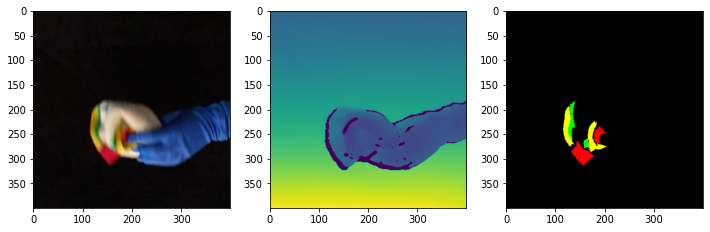

KeyboardInterrupt: 

In [121]:

# show a batch
batch_size = 2
for i in range(batch_size):
    sample = train_data[i]
    print(i, sample['X'].size())
    print(sample['X'].max(), sample['X'].min(), sample['X'].type())
    print(sample['Y'].max(), sample['Y'].min(), sample['Y'].type())
    print(sample['rgb'].max(), sample['rgb'].min(), sample['rgb'].type())

    a = sample['Y'].numpy()
    for i in range(a.shape[0]):
        for j in range(a.shape[1]):
            for k in range(a.shape[2]):
                if a[i,j,k] != 0 and a[i,j,k] != 1:
                    print(a[i,j,k])

dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=False, num_workers=1)

for i, batch in enumerate(dataloader):
    print(i, batch['X'].size())

    # observe 4th batch
    if i == 0:
        plt.figure()
        show_batch(batch)
        plt.axis('off')
        plt.ioff()
        plt.show()